In [159]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re 
import gensim
import pickle # Useful for storing big datasets
import nltk
from nltk.stem import *
from wordcloud import WordCloud
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import ipywidgets as widgets
from ipywidgets import interact

### Helper functions

In [160]:
# function to group dataset by features when rows can belong to multiple groups
def groupby_many(data, groups):
    """
    Groups a Series or DataFrame object where each row can belong to many groups.

    Parameters
    ----------
    data : Series or DataFrame
        The data to group
    groups : iterable of iterables
        For each row in data, the groups that row belongs to.
        A row can belong to zero, one, or multiple groups.

    Returns
    -------
    A GroupBy object    
    """ 
    pairs = [(i, g) for (i, gg) in enumerate(groups) for g in gg]
    row, group = zip(*pairs)
    return data.iloc[list(row)].groupby(list(group))


def draw_plot1(year):
    df=movies
    df=df[df['year']==year]
    fig, axs = plt.subplots(1)
    groupby_many(df, df['genres'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
    # groupby_many(df, df['genres'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
    # for ax in fig.get_axes():
    #     ax.label_outer()
    plt.title('plot of top genres of each year')


def draw_plot2(genre):
    df=movies
    df=df[df['genres'].apply(lambda x: genre in x)]
    fig, axs = plt.subplots(1)
    groupby_many(df, df['countries'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
    # groupby_many(df, df['countries'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
    # for ax in fig.get_axes():
    #     ax.label_outer()
    plt.title('plot of top countries for each genre')


# def draw_plot3(year):
#     df=movies
#     df=df[df['year']==year]
#     fig, axs = plt.subplots(1)
#     groupby_many(df, df['genres'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:blue',legend=True)
#     # groupby_many(df, df['genres'])[['revenue']].mean().sort_values('revenue',ascending=False)['revenue'][0:20].plot(kind='bar',ax=axs[1],color='tab:green',legend=True)

#     # for ax in fig.get_axes():
#     #     ax.label_outer()

#     plt.title('plot of richest genre of the year')


# def draw_plot4(genre):
#     df=movies_with_revenues
#     df=df[df['genres'].apply(lambda x: genre in x)]
#     fig, axs = plt.subplots(1)
#     groupby_many(df, df['countries'])[['revenue']].mean().sort_values('revenue',ascending=False)['revenue'][0:20].plot(kind='bar',color='tab:red',legend=True)
#     #groupby_many(df, df['countries'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
#     for ax in fig.get_axes():
#         ax.label_outer()
#     plt.title('Best countries for each genre')

### Loading the data and naming the columns 

In [161]:
path = 'MovieSummaries/'

character=pd.read_csv(path+'character.metadata.tsv',sep='\t',header=None, names=['wiki_movie_ID','Freebase_movie_ID','release_date','character_name','actor_birth','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID'])
cmu_movies = pd.read_csv(path+'movie.metadata.tsv',sep='\t',header=None,names=['wiki_movie_ID','Freebase_movie_ID','movie_name','date','revenue','runtime','languages','countries','genres'])
plot_summary = pd.read_csv(path+'plot_summaries.txt',sep='\t',header=None,names=['wiki_movie_ID','summary'])
imdb_movies = pd.read_csv(path+'imdb_title.tsv',sep='\t')
ratings = pd.read_csv(path+'rating.tsv',sep='\t')
complementary_data = pd.read_csv(path+'complementary_data.csv')
top_actor = pd.read_csv(path+'top_actor.csv')

/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_99131/2481042638.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_movies = pd.read_csv(path+'imdb_title.tsv',sep='\t')
/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_99131/2481042638.py:8: DtypeWarning: Columns (0,1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  complementary_data = pd.read_csv(path+'complementary_data.csv')


In [162]:
display('CHARACTERS:', character.head())
display('CMU MOVIES:',cmu_movies.head())
display('PLOT SUMMARIES:',plot_summary.head())
display('IMDB MOVIES:',imdb_movies.head())
display('RATINGS:',ratings.head())
display('COMPLEMENTARY:',complementary_data.head())
display('TOP ACTORS:',top_actor.head())

'CHARACTERS:'

,wiki_movie_ID,Freebase_movie_ID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


'CMU MOVIES:'

,wiki_movie_ID,Freebase_movie_ID,movie_name,date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


'PLOT SUMMARIES:'

,wiki_movie_ID,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


'IMDB MOVIES:'

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


'RATINGS:'

,tconst,averageRating,numVotes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1734
3,tt0000004,5.6,174
4,tt0000005,6.2,2546


'COMPLEMENTARY:'

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number
0,2,0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,0.823904,Villealfa Filmproduction Oy,Finland,...,69.0,suomi,Released,NaN,Ariel,7.1,40.0,2.0,1.0,2.0
1,3,0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",0.47445,Villealfa Filmproduction Oy,Finland,...,76.0,English,Released,NaN,Shadows in Paradise,7.0,32.0,1.0,1.0,3.0
2,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,1.698,Miramax Films,United States of America,...,98.0,English,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,485.0,2.0,1.0,1.0
3,6,0,Action|Thriller|Crime,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",1.32287,Universal Pictures,Japan,...,110.0,English,Released,Don't move. Don't whisper. Don't even breathe.,Judgment Night,6.5,69.0,3.0,2.0,1.0
4,8,42000,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,0.054716,inLoops,Austria,...,80.0,English,Released,A Megacities remix.,Life in Loops (A Megacities RMX),6.4,4.0,1.0,1.0,5.0


'TOP ACTORS:'

,Position,Const,Created,Modified,Description,Name,Known For,Birth Date
0,1,nm0000134,2014-03-09,2014-03-09,NaN,Robert De Niro,Raging Bull,1943-08-17
1,2,nm0000197,2014-03-09,2015-10-25,NaN,Jack Nicholson,Chinatown,1937-04-22
2,3,nm0000008,2014-03-09,2014-03-09,NaN,Marlon Brando,Apocalypse Now,1924-04-03
3,4,nm0000243,2014-03-09,2014-03-09,NaN,Denzel Washington,Fences,1954-12-28
4,5,nm0000031,2014-03-09,2014-03-09,NaN,Katharine Hepburn,The Lion in Winter,1907-05-12


In [163]:
#   UNIQUE MOVIE NAMES
print('Number of different movie names in CMU dataset : ',len(cmu_movies.movie_name.unique()))
print('Number of different movie names in IMDb dataset : ',len(imdb_movies.originalTitle.unique()))

Number of different movie names in CMU dataset :  75478
Number of different movie names in IMDb dataset :  4306431


In [164]:
# Create 2 features for the month and the year of releasing of the movies
cmu_movies['month_day'] = cmu_movies['date'].apply(lambda x: x[5:] if len(str(x))>3 else np.nan)
cmu_movies['year'] = cmu_movies['date'].apply(lambda x: x[0:4] if len(str(x))>3 else x)
cmu_movies=cmu_movies.drop('date', axis = 1)

### Merging CMU and IMDB datasets

In [165]:
merged_movies = cmu_movies.merge(imdb_movies,left_on=['movie_name', 'year'],right_on=['primaryTitle', 'startYear'], how="inner")
print('Size of the new dataset : ', merged_movies.shape)


Size of the new dataset :  (61079, 19)


In [166]:
#adding the ratings feature
movies_with_ratings= merged_movies.merge(ratings, left_on='tconst', right_on='tconst', how='inner')
print('Size of the dataset with the ratings : ', movies_with_ratings.shape)

Size of the dataset with the ratings :  (50834, 21)


In [167]:
movies_with_ratings.head()

,wiki_movie_ID,Freebase_movie_ID,movie_name,revenue,runtime,languages,countries,genres_x,month_day,year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",08-24,2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",4.9,55254
1,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",08-24,2001,...,tvEpisode,Ghosts of Mars,Ghosts of Mars,0,2001,\N,\N,"Documentary,Short",7.9,19
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",,1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",5.7,40
3,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",,1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,6.0,590
4,13696889,/m/03cfc81,The Gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",05-29,1913,...,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16


### Pre-process the data : cleaning, engineering and standardizing

In [168]:
#Dropping useless or redundant features
movies_with_ratings = movies_with_ratings.drop('genres_y', axis = 1)
movies_with_ratings = movies_with_ratings.rename(columns = {'genres_x':'genres'})
movies_with_ratings = movies_with_ratings.drop('Freebase_movie_ID', axis = 1)
movies_with_ratings = movies_with_ratings.drop('primaryTitle', axis = 1)
movies_with_ratings = movies_with_ratings.drop('originalTitle', axis = 1)
movies_with_ratings = movies_with_ratings.drop('runtimeMinutes', axis = 1)
movies_with_ratings = movies_with_ratings.drop('startYear', axis = 1)

movies_with_ratings['year']=movies_with_ratings['year'].astype(int)

In [169]:
#Remove the 'key' part of languages, countries and genres features
movies_with_ratings['languages'] = movies_with_ratings['languages'].apply(lambda x: list(json.loads(x).values()))
movies_with_ratings['countries'] = movies_with_ratings['countries'].apply(lambda x: list(json.loads(x).values()))
movies_with_ratings['genres'] = movies_with_ratings['genres'].apply(lambda x: list(json.loads(x).values()))

In [170]:
print('The percentage of null values for the feature endYear is', np.array(movies_with_ratings.endYear == '\\N').sum()/movies_with_ratings.shape[0])

The percentage of null values for the feature endYear is 0.993390250619664


The percentage of rows containing the feature endYear is very low, so we remove this feature.

In [171]:
movies_with_ratings = movies_with_ratings.drop('endYear', axis = 1)

In [172]:
#removing movies with no votes
movies_with_ratings = movies_with_ratings[movies_with_ratings['numVotes']>0]

In [173]:
movies_with_ratings.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55254
1,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0594845,tvEpisode,0,7.9,19
2,28463795,Brun bitter,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",,1988,tt0094806,movie,0,5.7,40
3,261236,A Woman in Flames,NaN,106.0,[German Language],[Germany],[Drama],,1983,tt0083949,movie,0,6.0,590
4,13696889,The Gangsters,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",05-29,1913,tt0002894,short,0,6.8,16


In [174]:
#adding the budget feature
movies= movies_with_ratings.merge(complementary_data[['imdb_id','budget', 'popularity','production_companies']], left_on='tconst', right_on='imdb_id', how='inner')
print('Size of the dataset with the ratings : ', movies.shape)

Size of the dataset with the ratings :  (42638, 18)


In [175]:
#adding profit column
movies['budget'] = movies['budget'].astype(float)
movies['revenue'] = movies['revenue'].astype(float)
movies['profit'] = movies['revenue'] - movies['budget']
movies.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,imdb_id,budget,popularity,production_companies,profit
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55254,tt0228333,28000000.0,1.124671,Screen Gems,-13989168.0
1,28463795,Brun bitter,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",,1988,tt0094806,movie,0,5.7,40,tt0094806,0.0,1.80E-05,none,NaN
2,261236,A Woman in Flames,NaN,106.0,[German Language],[Germany],[Drama],,1983,tt0083949,movie,0,6.0,590,tt0083949,0.0,0.123849,Dieter Geissler Filmproduktion,NaN
3,13696889,The Gangsters,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",05-29,1913,tt0002894,short,0,6.8,16,tt0002894,0.0,0.000347,Keystone Film Company,NaN
4,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",08-16,1938,tt0029852,movie,0,6.9,2159,tt0029852,2000000.0,0.169786,Twentieth Century Fox Film Corporation,1600000.0


In [176]:
movies=movies[movies.revenue>0]
movies=movies[movies.budget!=0]
display(movies)

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,imdb_id,budget,popularity,production_companies,profit
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55254,tt0228333,28000000.0,1.124671,Screen Gems,-13989168.0
4,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",08-16,1938,tt0029852,movie,0,6.9,2159,tt0029852,2000000.0,0.169786,Twentieth Century Fox Film Corporation,1600000.0
7,171005,Henry V,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",11-08,1989,tt0097499,movie,0,7.5,30169,tt0097499,9000000.0,1.161514,BBC Films,1161099.0
8,77856,Mary Poppins,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",08-27,1964,tt0058331,movie,0,7.8,173264,tt0058331,6000000.0,4.882687,Walt Disney Productions,96272727.0
15,156558,Baby Boy,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",06-27,2001,tt0255819,movie,0,6.4,15002,tt0255819,16000000.0,1.07838,Columbia Pictures,13381649.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42577,2472440,Turbulence,11538235.0,101.0,[English Language],[United States of America],"[Thriller, Disaster, Action, Action/Adventure]",01-10,1997,tt0120390,movie,0,4.9,11927,tt0120390,55000000.0,1.640388,Metro-Goldwyn-Mayer (MGM),-43461765.0
42595,303933,Twister,494471524.0,113.0,[English Language],[United States of America],"[Action/Adventure, Disaster]",05-10,1996,tt0117998,movie,0,6.4,197559,tt0117998,92000000.0,3.535778,Universal Pictures,402471524.0
42596,25920477,Source Code,147332697.0,93.0,[English Language],"[France, United States of America]","[Thriller, Science Fiction, Action/Adventure, ...",03-11,2011,tt0945513,movie,0,7.5,520749,tt0945513,32000000.0,4.41211,The Mark Gordon Company,115332697.0
42614,54540,Coming to America,288752301.0,117.0,[English Language],[United States of America],"[Romantic comedy, Comedy of manners, Drama, Co...",06-29,1988,tt0094898,movie,0,7.1,208621,tt0094898,39000000.0,2.50055,Paramount Pictures,249752301.0


#### Sucess metrics

In [177]:
movies["weighted_rating"]=movies.numVotes.apply(np.log10)*movies.averageRating

'''or instead if we choose popularity'''
#movies["weighted_rating"]=movies.popularity*movies.averageRating


'or instead if we choose popularity'

In [178]:
# normalize the profit and weighter_rating columns
COLUMNS = ['profit', 'weighted_rating']

for i in range(len(COLUMNS)):
     movies[COLUMNS] = (movies[COLUMNS] - movies[COLUMNS].mean())/(movies[COLUMNS].std())


In [179]:
# calculate the success metrics
movies["success"]= (movies.weighted_rating + movies.profit)/2

In [180]:
movies.success.describe()

count    3.681000e+03
mean    -1.544238e-17
std      8.418193e-01
min     -1.827856e+00
25%     -5.289487e-01
50%     -1.266511e-01
75%      3.721134e-01
max      1.088301e+01
Name: success, dtype: float64

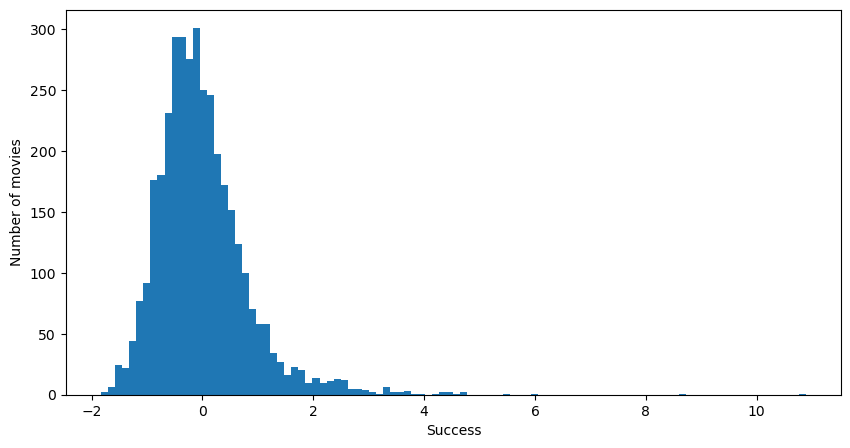

In [181]:
plt.figure(figsize=(10,5))
plt.hist(movies.success, bins=100)
plt.xlabel('Success')
plt.ylabel('Number of movies')
plt.show()

#### We will now check for non unicity of the movies in the dataset:

In [182]:
duplicates = movies.loc[movies.duplicated(subset=['wiki_movie_ID', 'titleType'], keep = False)]

In [183]:
duplicates.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,...,isAdult,averageRating,numVotes,imdb_id,budget,popularity,production_companies,profit,weighted_rating,success
36169,7376937,Asylum,69290289.0,93.0,[English Language],[United States of America],"[Thriller, Horror, Psychological thriller, Sup...",07-15,2008,tt0804443,...,0,4.0,3783,tt0804443,22000000.0,0.357426,Hyde Park Films,-0.068944,-2.102721,-1.085833
36170,7376937,Asylum,69290289.0,93.0,[English Language],[United States of America],"[Thriller, Horror, Psychological thriller, Sup...",07-15,2008,tt0856162,...,0,6.3,83,tt0856162,4000.0,0.000576,none,0.104498,-2.386193,-1.140847


We will consider as duplicates the movies having same title and titleType. Our strategy is to drop duplicates, keeping the movie with the highest 'popularity', i.e. highest vote count

In [184]:
for i in range(len(duplicates.wiki_movie_ID.unique())):# for loop per each duplicate
    orig = movies[movies.wiki_movie_ID == duplicates.wiki_movie_ID.unique()[i]] # find them in the original dataset
    movies = movies.drop(list(orig[orig.numVotes !=orig.numVotes.max()].index)) # drop rows that don't have the maximum number of votes


In [185]:
#there are movies with the same Id but different titleType and rating
movies.loc[movies.duplicated(subset=['wiki_movie_ID'], keep = False)].head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,...,isAdult,averageRating,numVotes,imdb_id,budget,popularity,production_companies,profit,weighted_rating,success
7841,535335,War of the Worlds,591745550.0,112.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",06-13,2005,tt0407304,...,0,6.5,449389,tt0407304,132000000.0,5.685105,Paramount Pictures,3.183340,0.759968,1.971654
7842,535335,War of the Worlds,591745550.0,112.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",06-13,2005,tt0449040,...,0,3.2,2656,tt0449040,1000000.0,0.571862,Asylum,4.216298,-2.530747,0.842775


In [186]:
#keep only principal genres 

principal_genres=['Action','Comedy','Drama','Fantasy','Horror','Romance Film','Science Fiction','Thriller','Western']

def common_data(list1, list2):
    a_set = set(list1)
    b_set = set(list2)
    intersec = a_set.intersection(b_set)
    if len(intersec) > 0:
        return list(intersec)
    else : 
        return 0
        


movies['genres']= movies['genres'].apply(lambda x: common_data(x,principal_genres))
movies = movies[movies['genres']!=0]
display(movies)


,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,...,isAdult,averageRating,numVotes,imdb_id,budget,popularity,production_companies,profit,weighted_rating,success
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Action, Horror, Science Fiction, Thriller]",08-24,2001,tt0228333,...,0,4.9,55254,tt0228333,28000000.0,1.124671,Screen Gems,-0.552144,-0.963522,-0.757833
4,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],[Comedy],08-16,1938,tt0029852,...,0,6.9,2159,tt0029852,2000000.0,0.169786,Twentieth Century Fox Film Corporation,-0.429220,-0.993033,-0.711127
7,171005,Henry V,10161099.0,137.0,[English Language],[United Kingdom],[Drama],11-08,1989,tt0097499,...,0,7.5,30169,tt0097499,9000000.0,1.161514,BBC Films,-0.432681,0.358548,-0.037066
8,77856,Mary Poppins,102272727.0,139.0,[English Language],[United States of America],"[Fantasy, Drama, Comedy]",08-27,1964,tt0058331,...,0,7.8,173264,tt0058331,6000000.0,4.882687,Walt Disney Productions,0.317291,1.285762,0.801527
15,156558,Baby Boy,29381649.0,123.0,[English Language],[United States of America],[Drama],06-27,2001,tt0255819,...,0,6.4,15002,tt0255819,16000000.0,1.07838,Columbia Pictures,-0.336320,-0.518144,-0.427232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42567,10149834,Ponyo,202614288.0,101.0,[Japanese Language],[Japan],"[Fantasy, Drama]",07-19,2008,tt0876563,...,0,7.6,144475,tt0876563,41677699.0,4.196854,Studio Ghibli,0.827177,1.075502,0.951340
42577,2472440,Turbulence,11538235.0,101.0,[English Language],[United States of America],"[Action, Thriller]",01-10,1997,tt0120390,...,0,4.9,11927,tt0120390,55000000.0,1.640388,Metro-Goldwyn-Mayer (MGM),-0.784540,-1.379904,-1.082222
42596,25920477,Source Code,147332697.0,93.0,[English Language],"[France, United States of America]","[Action, Drama, Science Fiction, Thriller]",03-11,2011,tt0945513,...,0,7.5,520749,tt0945513,32000000.0,4.41211,The Mark Gordon Company,0.467583,1.542642,1.005112
42614,54540,Coming to America,288752301.0,117.0,[English Language],[United States of America],"[Romance Film, Drama, Comedy]",06-29,1988,tt0094898,...,0,7.1,208621,tt0094898,39000000.0,2.50055,Paramount Pictures,1.527505,0.890833,1.209169


### Visualization of the data

In [187]:
#plot of the top 20 languages 
languages_20 = groupby_many(movies, movies['languages'])[['success']].mean().sort_values('success', ascending=False)[0:20]
display(languages_20)

,success
Old English language,3.505716
Amharic Language,2.574104
Assyrian language,2.574104
Sicilian Language,2.527771
Nepali Language,2.487863
Pawnee Language,2.169448
Zulu Language,2.004216
Xhosa Language,2.004216
Croatian language,1.832407
Hmong language,1.792558


#### Distributions

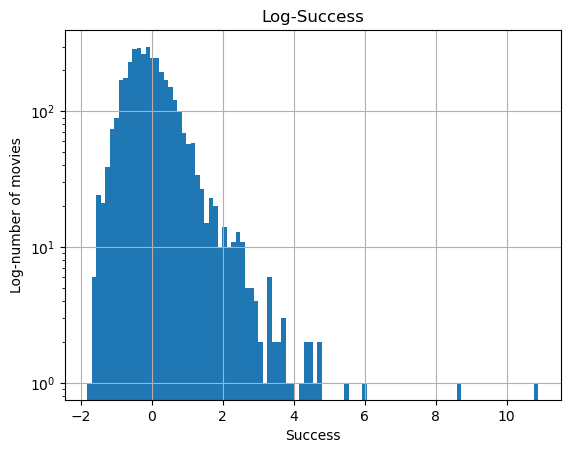

In [188]:
fig, axes = plt.subplots(1, 1)

movies.success.hist(bins=100, log=True)
axes.set_title('Log-Success')
axes.set_xlabel('Success')
axes.set_ylabel('Log-number of movies')
plt.show()

In [189]:
movies.groupby('titleType').count()['wiki_movie_ID']

titleType
movie    3608
short       1
video       9
Name: wiki_movie_ID, dtype: int64

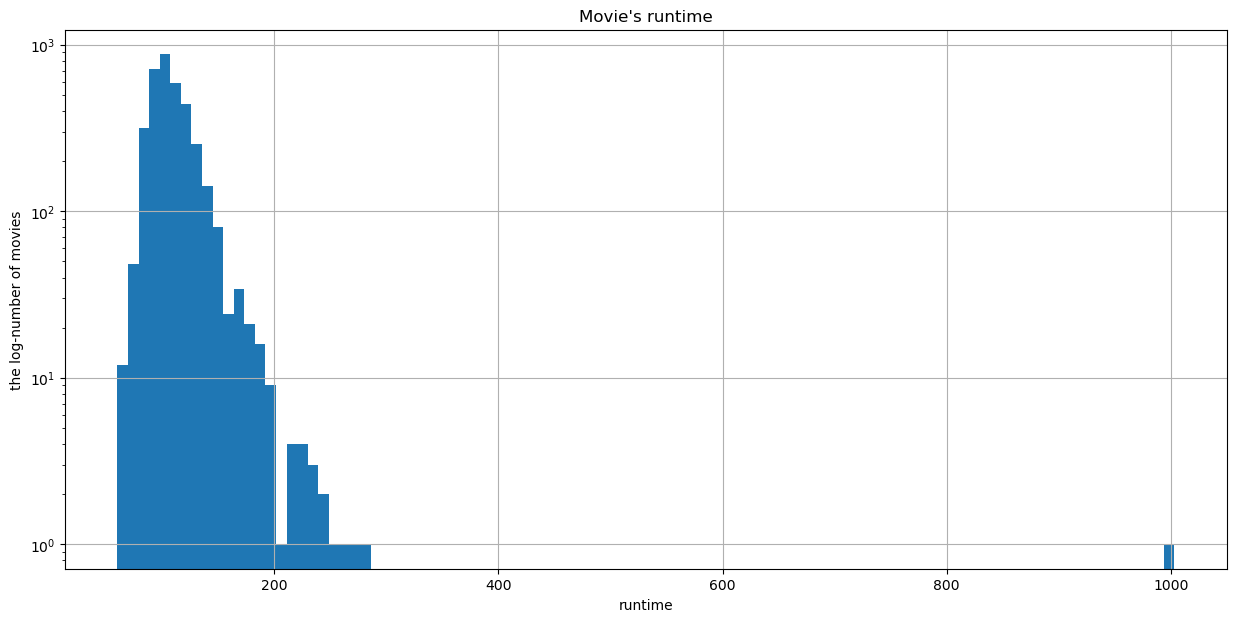

In [190]:
movies[movies['titleType'] == 'movie']['runtime'].hist(bins=100,log=True,figsize=(15,7))
plt.title('Movie\'s runtime')
plt.xlabel('runtime')
plt.ylabel('the log-number of movies')
plt.show()

#### Top languages, countries, and genres

Text(0.5, 1.0, 'plot of top 20 languages')

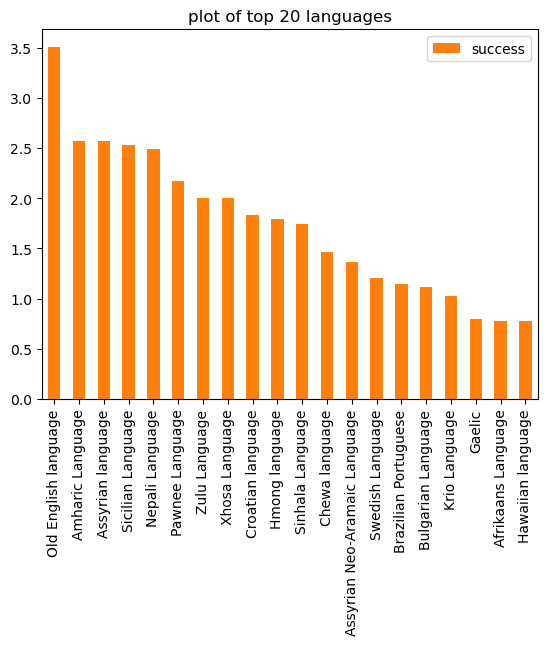

In [191]:
fig, axs = plt.subplots(1)
groupby_many(movies, movies['languages'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
# groupby_many(movies, movies['languages'])[['success']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
# for ax in fig.get_axes():
#     ax.label_outer()

plt.title('plot of top 20 languages')


Text(0.5, 1.0, 'plot of top 20 countries')

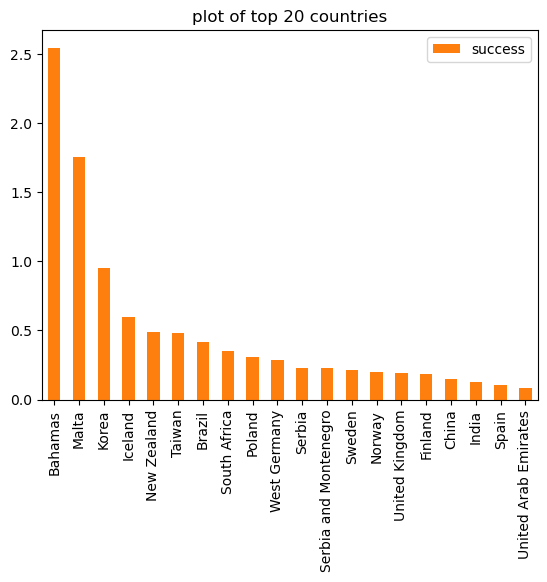

In [192]:
#groupby_many(movies_with_ratings, movies_with_ratings['countries'])[['averageRating', 'numVotes']].mean().sort_values('numVotes', ascending=False)[0:20].plot(kind='bar')
#plt.title('plot of 20 best rated countries')

fig, axs = plt.subplots(1)
groupby_many(movies, movies['countries'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
# groupby_many(movies, movies['countries'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
# for ax in fig.get_axes():
#     ax.label_outer()

plt.title('plot of top 20 countries')

In [193]:
# find 'Bahamas' in the countries column
print(movies[movies['countries'].apply(lambda x: 'Bahamas' in x)].index)
list(movies[movies.index == 1750]['countries'])

Int64Index([20639], dtype='int64')


[]

We can notice there was only one movie which was produced in the Bahamas and that this movie was produced in other 4 countries too. Let's investigate if the number of countries in which the movies is produced affects the success in some way.

In [194]:
# add a column which contains the number of countries
movies['num_countries'] = movies['countries'].apply(lambda x: len(x))

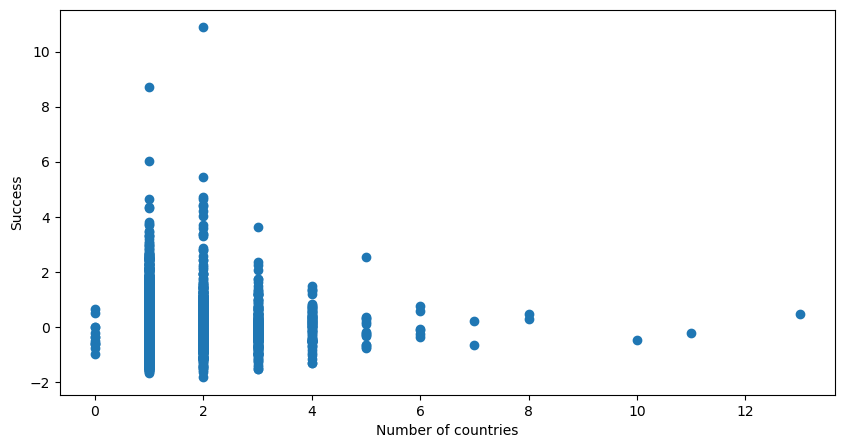

In [195]:
# plot the number of countries vs the success
plt.figure(figsize=(10,5))
plt.scatter(movies['num_countries'], movies['success'])
plt.xlabel('Number of countries')
plt.ylabel('Success')
plt.show()


Text(0.5, 1.0, 'plot of top 20 genres')

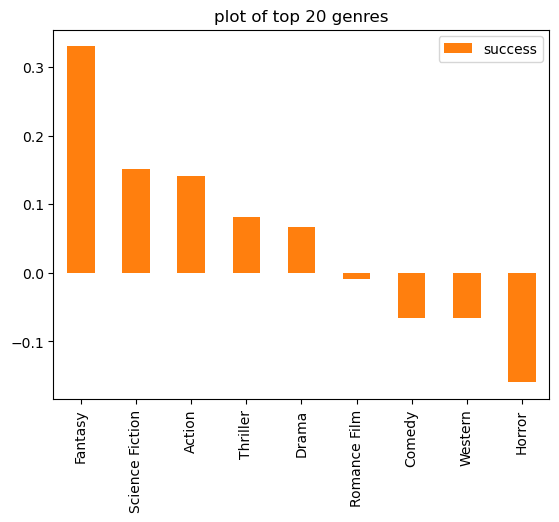

In [196]:
fig, axs = plt.subplots(1)
groupby_many(movies, movies['genres'])[['success']].mean().sort_values('success',ascending=False)['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
# groupby_many(movies, movies['genres'])[['averageRating','numVotes']].mean().sort_values('numVotes',ascending=False)['averageRating'][0:20].plot(kind='bar',ax=axs[1],legend=True)
# for ax in fig.get_axes():
#     ax.label_outer()

plt.title('plot of top 20 genres')



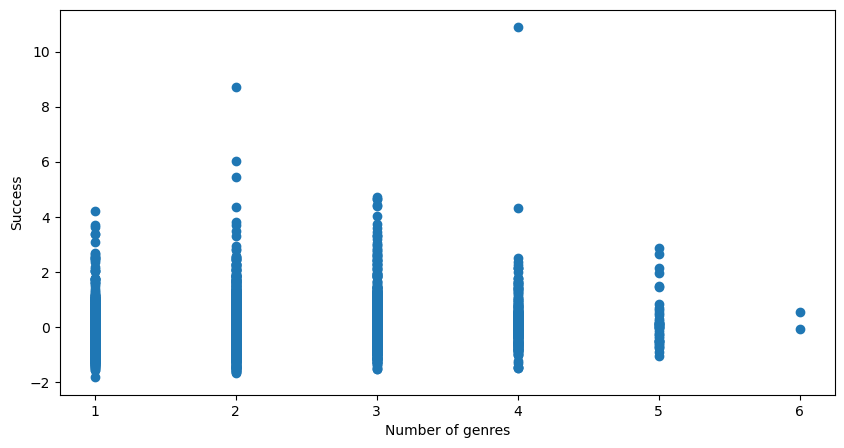

In [197]:
# add a column with the number of genres
movies['num_genres'] = movies['genres'].apply(lambda x: len(x))
# plot the number of genres vs the success
plt.figure(figsize=(10,5))
plt.scatter(movies['num_genres'], movies['success'])
plt.xlabel('Number of genres')
plt.ylabel('Success')
plt.show()

This looks that the number of genres is not affecting the success. No special patter in recognizable.

#### Each year's best genre

In [198]:
slider=widgets.IntSlider(min=movies['year'].min(),max=movies['year'].max(),description='year')
interact(draw_plot1,year=slider)
#display(slider,out)

interactive(children=(IntSlider(value=1915, description='year', max=2012, min=1915), Output()), _dom_classes=(…

<function __main__.draw_plot1(year)>

#### The best countries for each genre

In [199]:
pairs = [(i, g) for (i, gg) in enumerate(movies['genres']) for g in gg]
row, group = zip(*pairs)
group=np.unique(group)
dd= widgets.Dropdown(options=group,value=group[0],description='Select a genre')

interact(draw_plot2,genre=dd)
display(slider)

interactive(children=(Dropdown(description='Select a genre', options=('Action', 'Comedy', 'Drama', 'Fantasy', …

IntSlider(value=1915, description='year', max=2012, min=1915)

Correlation between runtime and revenue (for normal timed movies: 50-200 minutes)

In [200]:
normal_time_movies= movies[((movies.runtime>=50) & (movies.runtime<=200))]
normal_time_movies.shape

(3583, 23)

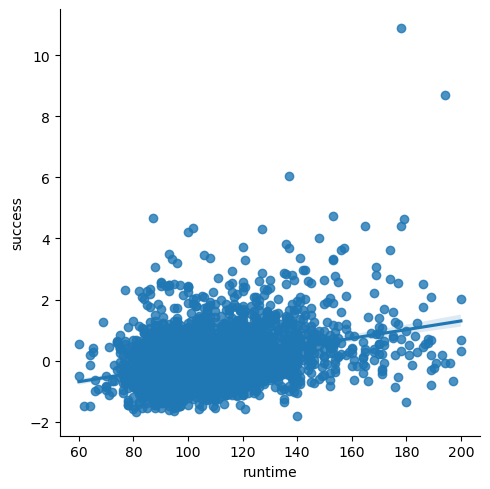

In [201]:
sns.lmplot(x='runtime', y='success', data=normal_time_movies[['success', 'runtime']])
plt.show()

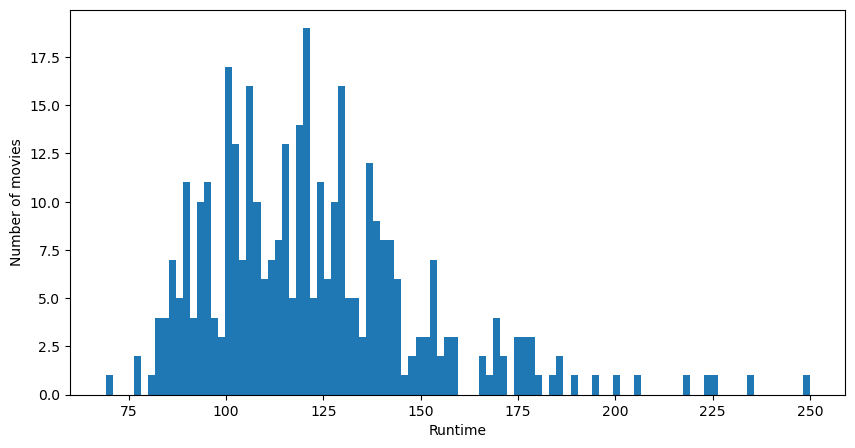

In [202]:
# plot the runtime of the upper 10% of the most successful movies
plt.figure(figsize=(10,5))
plt.hist(movies[movies['success'] > movies['success'].quantile(0.9)]['runtime'], bins=100)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.show()


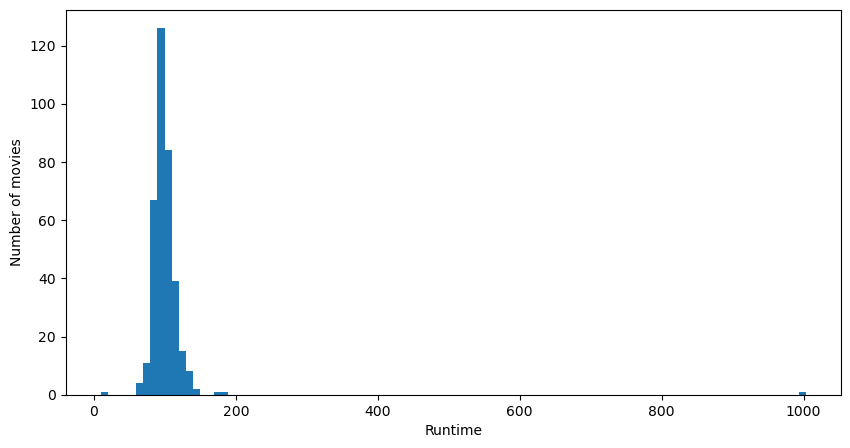

In [203]:
plt.figure(figsize=(10,5))
plt.hist(movies[movies['success'] < movies['success'].quantile(0.10)]['runtime'], bins=100)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.show()

In [204]:
# which is the movie with the longest runtime?
movies[movies['runtime'] == movies['runtime'].max()]

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,...,numVotes,imdb_id,budget,popularity,production_companies,profit,weighted_rating,success,num_countries,num_genres
29827,2551150,Rebound,17492014.0,1003.0,[English Language],[United States of America],[Comedy],07-01,2005,tt0376108,...,13162,tt0376108,45000000.0,1.034741,Twentieth Century Fox Film Corporation,-0.658742,-1.248,-0.953371,1,1


/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_99131/2843164691.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(movies.corr(), annot=True, cmap='coolwarm')


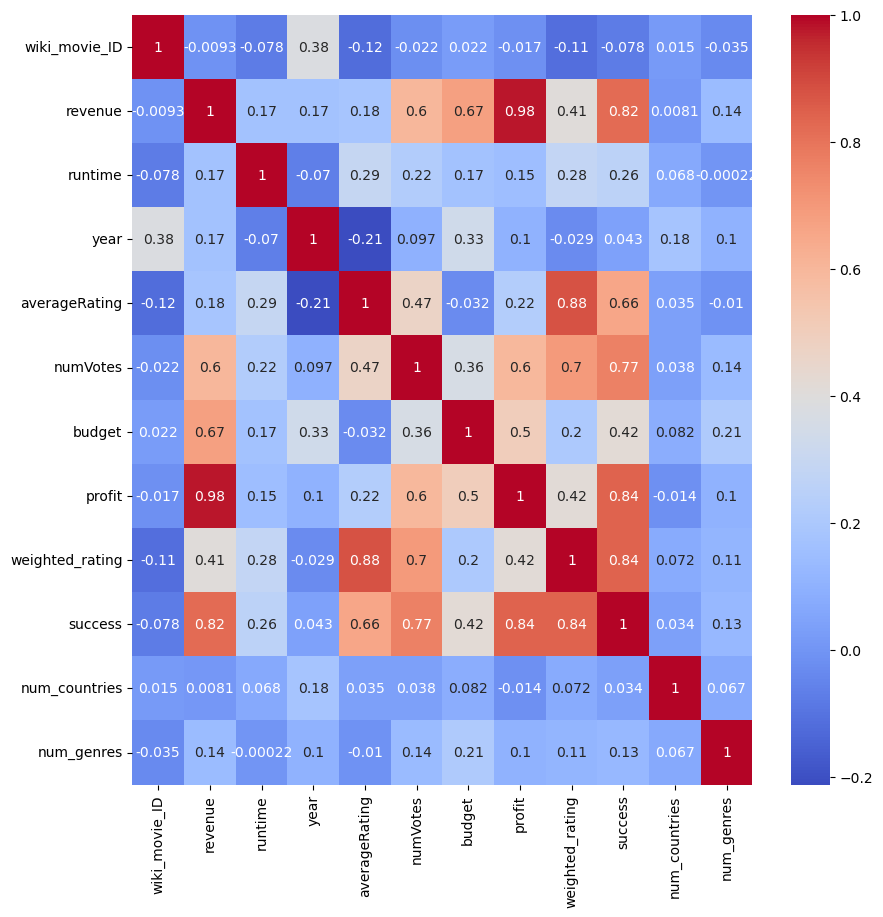

In [205]:
# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(movies.corr(), annot=True, cmap='coolwarm')
plt.show()

In [206]:
#Linear dependence
normal_time_movies[['success', 'runtime']].corr()

,success,runtime
success,1.000000,0.334619
runtime,0.334619,1.000000


In [207]:
#Strength of association (spearman's correlation)
normal_time_movies.success.corr(normal_time_movies.runtime, method='spearman')

0.31826066845271817

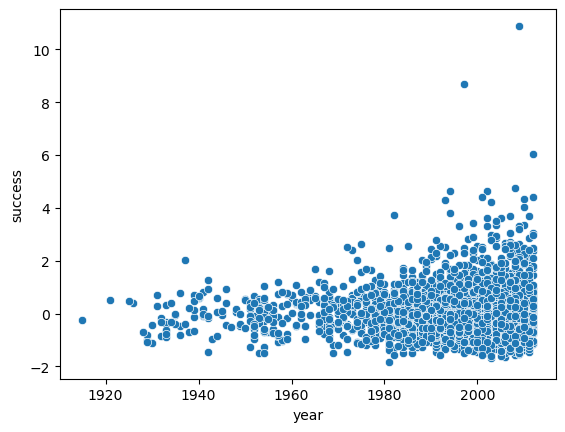

In [208]:
sns.scatterplot(x='year', y='success', data=normal_time_movies[['success', 'year']])
plt.show()

<AxesSubplot: xlabel='month', ylabel='success'>

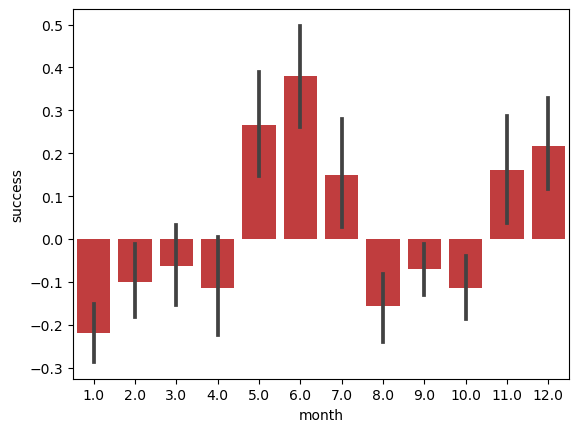

In [209]:
from datetime import datetime
movies['month'] = movies['month_day'].apply(lambda x :(int(x[1]) if x[0]=='0' else int(x[0:2])) if len(x)>0 else None)
df=movies.groupby(movies['month'])['success'].mean()
sns.barplot(data=movies,x=movies['month'],y=movies['success'],color='tab:red')

In [210]:
top_actor

,Position,Const,Created,Modified,Description,Name,Known For,Birth Date
0,1,nm0000134,2014-03-09,2014-03-09,NaN,Robert De Niro,Raging Bull,1943-08-17
1,2,nm0000197,2014-03-09,2015-10-25,NaN,Jack Nicholson,Chinatown,1937-04-22
2,3,nm0000008,2014-03-09,2014-03-09,NaN,Marlon Brando,Apocalypse Now,1924-04-03
3,4,nm0000243,2014-03-09,2014-03-09,NaN,Denzel Washington,Fences,1954-12-28
4,5,nm0000031,2014-03-09,2014-03-09,NaN,Katharine Hepburn,The Lion in Winter,1907-05-12
...,...,...,...,...,...,...,...,...
995,996,nm3485845,2019-03-19,2019-03-19,NaN,Adam Driver,Star Wars: Episode VII - The Force Awakens,1983-11-19
996,997,nm0000885,2014-03-10,2014-03-10,NaN,Ned Beatty,Network,1937-07-06
997,998,nm0000092,2014-03-10,2014-03-10,NaN,John Cleese,A Fish Called Wanda,1939-10-27
998,999,nm0001806,2014-03-10,2014-03-10,NaN,John Turturro,Barton Fink,1957-02-28


In [211]:
movies_and_actors = movies.merge(character,on='wiki_movie_ID',how='inner')

top = 300
top_actor = top_actor[top_actor['Position']<top]

movies_and_actors['IsFamousActor']=movies_and_actors['actor_name'].isin(top_actor['Name'])

famous=movies_and_actors.groupby('wiki_movie_ID')['IsFamousActor'].apply(lambda x : any(x)).to_frame('IsFamousActor')

movies=movies.merge(famous,on='wiki_movie_ID',how='left')
movies['IsFamousActor']=movies['IsFamousActor'].apply(lambda x : x if np.isnan(x) else int(x))

<AxesSubplot: xlabel='IsFamousActor', ylabel='success'>

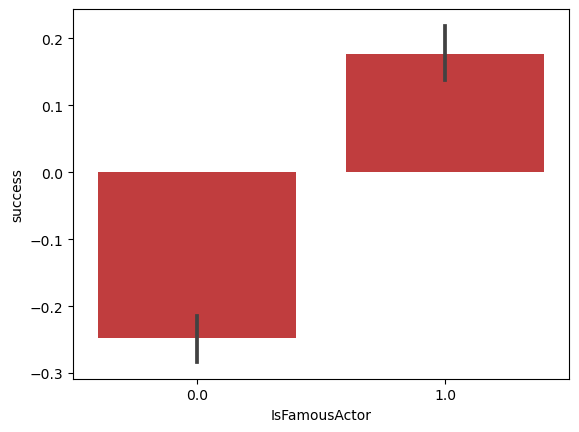

In [212]:
sns.barplot(data=movies,x=movies['IsFamousActor'],y=movies['success'],color='tab:red')

,actor_age,success
wiki_movie_ID,,
3217,33.250000,0.336842
3333,11.000000,-0.249209
3746,38.384615,0.876355
3837,45.550000,0.804420
3947,NaN,0.429248
...,...,...
35370504,41.500000,0.309797
35581515,61.000000,0.112940
35729649,34.750000,0.547676


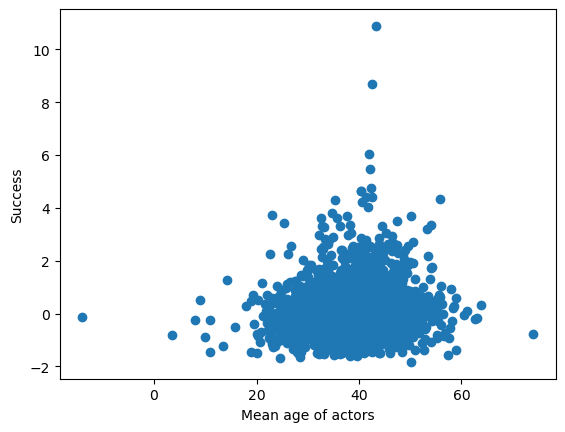

In [213]:
age = movies_and_actors.groupby('wiki_movie_ID')[['actor_age','success']].mean()
display(age)
age=age.dropna()

plt.scatter(age['actor_age'],age['success'])
plt.xlabel('Mean age of actors')
plt.ylabel('Success')
plt.show()


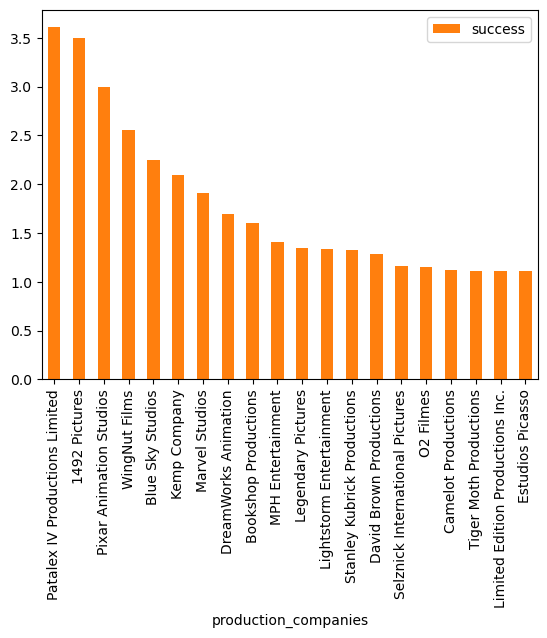

<AxesSubplot: xlabel='IsMajorProducer', ylabel='success'>

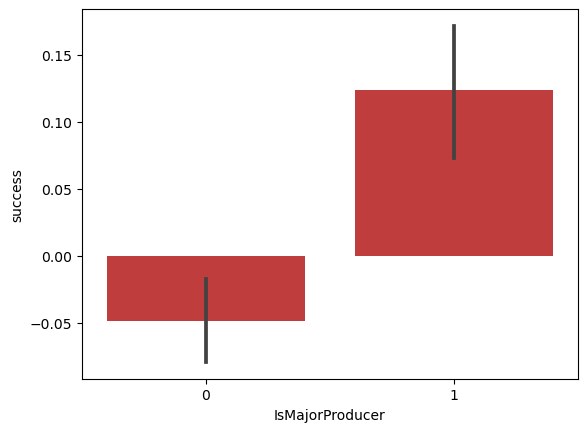

In [214]:
producer = movies.groupby('production_companies')[['success']].mean().sort_values('success',ascending=False)
producer['success'][0:20].plot(kind='bar',color='tab:orange',legend=True)
plt.show()

major_producer = ['Universal International Pictures (UI)', 'Universal Pictures','Universal Pictures Corporation', 'Universal Pictures International (UPI)','Paramount Pictures' ,'Paramount Pictures Corporation','Warner Bros.','Warner Bros. Pictures','New Line Cinema','Walt Disney Pictures','Walt Disney Productions','20th Century Fox','Columbia Pictures', 'Columbia Pictures Corporation',
'Columbia Pictures Industries','TriStar Pictures'] ## source : wikipedia
movies['IsMajorProducer']=movies['production_companies'].isin(major_producer)
movies['IsMajorProducer']=movies['IsMajorProducer'].apply(lambda x : x if np.isnan(x) else int(x))

sns.barplot(data=movies,x=movies['IsMajorProducer'],y=movies['success'],color='tab:red')

In [220]:
movies.columns

Index(['wiki_movie_ID', 'movie_name', 'revenue', 'runtime', 'languages',
       'countries', 'genres', 'month_day', 'year', 'tconst', 'titleType',
       'isAdult', 'averageRating', 'numVotes', 'imdb_id', 'budget',
       'popularity', 'production_companies', 'profit', 'weighted_rating',
       'success', 'num_countries', 'num_genres', 'month', 'IsFamousActor',
       'IsMajorProducer'],
      dtype='object')

In [227]:
movies_for_reg= movies[['success','year','titleType','month','IsFamousActor','runtime','IsMajorProducer', 'num_countries', 'num_genres']]

mlb_g = MultiLabelBinarizer()

g=pd.DataFrame(mlb_g.fit_transform(movies['genres']),columns=mlb_g.classes_, index=movies.index)

movies_for_reg=pd.concat([movies_for_reg,g], axis=1)
movies_for_reg=pd.get_dummies(movies_for_reg)
movies_for_reg=movies_for_reg.dropna()
display(movies_for_reg)
X= sm.add_constant( movies_for_reg.drop('success', axis=1) )
model = sm.OLS(movies_for_reg['success'],X).fit()
print(model.summary())

,success,year,month,IsFamousActor,runtime,IsMajorProducer,num_countries,num_genres,Action,Comedy,Drama,Fantasy,Horror,Romance Film,Science Fiction,Thriller,Western,titleType_movie,titleType_short,titleType_video
0,-0.757833,2001,8.0,0.0,98.0,0,1,4,1,0,0,0,1,0,1,1,0,1,0,0
1,-0.711127,1938,8.0,0.0,106.0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0
2,-0.037066,1989,11.0,1.0,137.0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0
3,0.801527,1964,8.0,1.0,139.0,1,1,3,0,1,1,1,0,0,0,0,0,1,0,0
4,-0.427232,2001,6.0,0.0,123.0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,-0.281026,1992,3.0,1.0,103.0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0
3613,0.951340,2008,7.0,1.0,101.0,0,1,2,0,0,1,1,0,0,0,0,0,1,0,0
3614,-1.082222,1997,1.0,0.0,101.0,0,1,2,1,0,0,0,0,0,0,1,0,1,0,0
3615,1.005112,2011,3.0,1.0,93.0,0,2,4,1,0,1,0,0,0,1,1,0,1,0,0


                            OLS Regression Results                            
Dep. Variable:                success   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     33.99
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          1.48e-102
Time:                        13:16:05   Log-Likelihood:                -3933.5
No. Observations:                3324   AIC:                             7903.
Df Residuals:                    3306   BIC:                             8013.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.1175      1.560     

## Analyze the plot summaries

In [216]:
#!pip install -U gensim==3.8.3
#nltk.download('punkt') # For Stemming
#nltk.download('wordnet') # For Lemmatization
#nltk.download('stopwords') # For Stopword Removal
#nltk.download('omw-1.4')


In [228]:
stopwords = set(nltk.corpus.stopwords.words('english'))

# Remove URLs
def remove_url(text):
    return re.sub(r'https?:\S*','',text)

# Remove mentions and hashtags
def remove_mentions_and_tags(text):
    text = re.sub(r'@\S*','',text)
    text = re.sub(r"\s*[A-Z]\w*\s*", " ", text)
    return re.sub(r'#\S*','',text)

def text_preprocessing(df):
    corpus=[]
    
    lem = WordNetLemmatizer() # For Lemmatization
    stem = PorterStemmer()
    for text in df['summary']:
        words=[w for w in nltk.tokenize.word_tokenize(text) if (w not in stopwords)] # word_tokenize function tokenizes text on each word by default
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        words=[stem.stem(w) for w in words]
        corpus.append(words)
    return corpus


In [229]:
principal_genres=['Action','Comedy','Drama','Fantasy','Horror','Romance Film','Science Fiction','Thriller','Western']
min_success = 0.7


plots = plot_summary.merge(movies,on='wiki_movie_ID') ##.merge(movies[['wiki_movie_ID','averageRating','numVotes','genres']],on='wiki_movie_ID')

plots = plots[plots['success']>=min_success]
plots_by_genre = groupby_many(plots, plots['genres'])
pd.options.mode.chained_assignment = None
    

Action
 
Topic: 0 
Words: 0.014*"kill" + 0.009*"escap" + 0.009*"find" + 0.007*"take" + 0.006*"discov" + 0.006*"use" + 0.006*"reveal" + 0.006*"return" + 0.006*"team" + 0.006*"one"
Topic: 1 
Words: 0.010*"dream" + 0.007*"son" + 0.006*"fight" + 0.006*"love" + 0.006*"brother" + 0.005*"seek" + 0.005*"memori" + 0.004*"armi" + 0.004*"father" + 0.004*"die"
Topic: 2 
Words: 0.009*"exhibit" + 0.008*"raider" + 0.006*"park" + 0.005*"film" + 0.005*"local" + 0.005*"crew" + 0.005*"box" + 0.005*"three" + 0.005*"round" + 0.004*"idea"
Topic: 3 
Words: 0.014*"polic" + 0.011*"car" + 0.010*"-su" + 0.009*"murder" + 0.009*"money" + 0.007*"shoot" + 0.006*"offic" + 0.006*"gang" + 0.006*"drug" + 0.006*"kill"
 
Comedy
 
Topic: 0 
Words: 0.007*"find" + 0.007*"tell" + 0.007*"get" + 0.006*"love" + 0.006*"time" + 0.006*"friend" + 0.006*"meet" + 0.006*"make" + 0.005*"return" + 0.005*"day"
Topic: 1 
Words: 0.012*"find" + 0.009*"escap" + 0.009*"fall" + 0.007*"anim" + 0.007*"tri" + 0.007*"attempt" + 0.006*"save" + 0.006

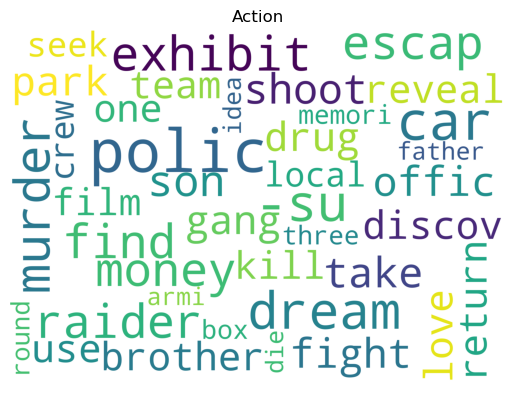

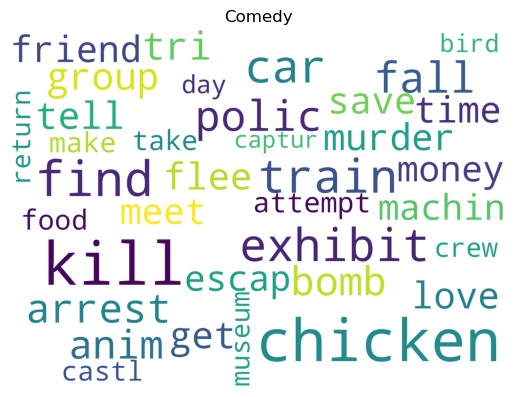

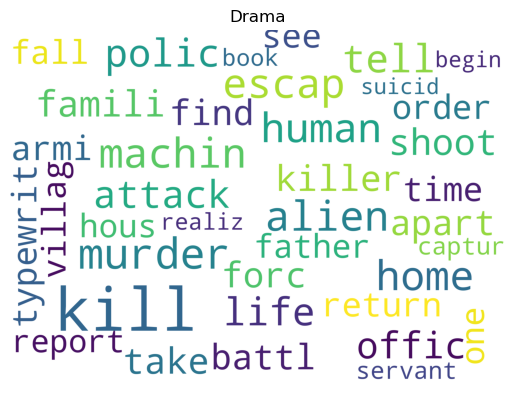

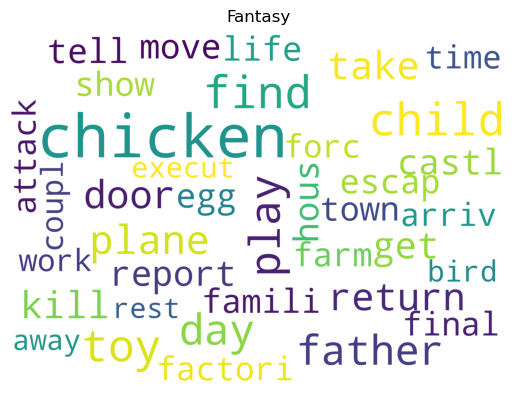

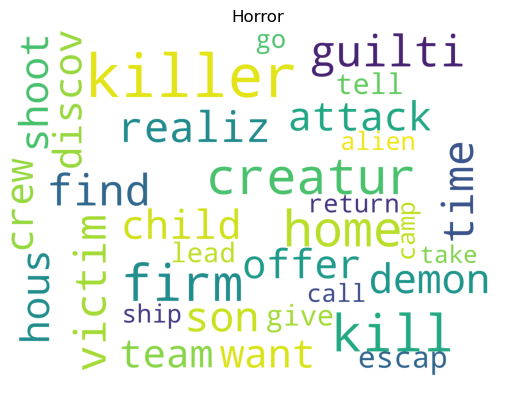

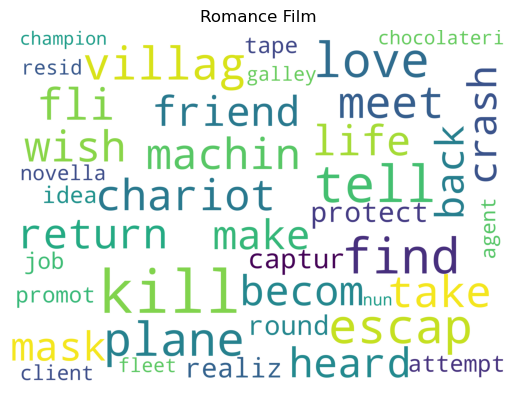

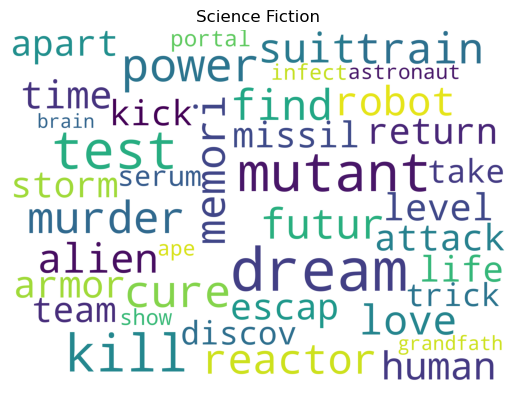

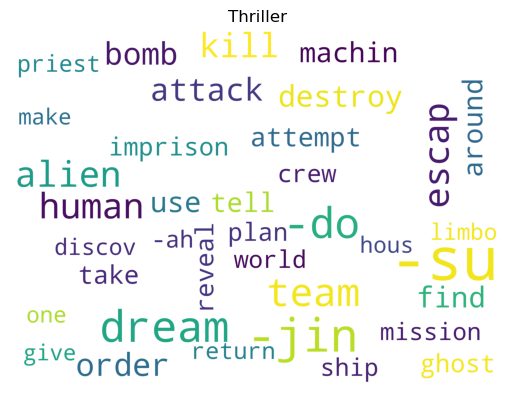

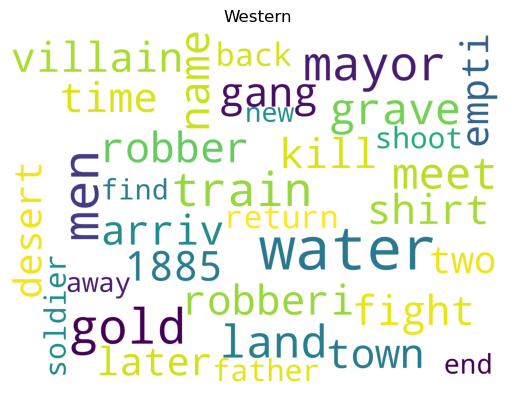

In [230]:
for genre in principal_genres : 

    print(genre)
    print(' ')
    genre_movies = plots_by_genre.get_group(genre)
    genre_movies['summary']=genre_movies['summary'].apply(remove_url)
    genre_movies['summary']=genre_movies['summary'].apply(remove_mentions_and_tags)
    corpus = text_preprocessing(genre_movies)
    # Transform to gensim dictionary
    dic = gensim.corpora.Dictionary(corpus) 
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    pickle.dump(bow_corpus, open('corpus_'+genre+'.pkl', 'wb'))
    dic.save('dictionary_'+genre+'.gensim')
    lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, id2word=dic,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
    
    # We print words occuring in each of the topics as we iterate through them
    for idx, topic in lda_model.print_topics(num_words=10):    
        print('Topic: {} \nWords: {}'.format(idx, topic))
        
    print(" ")
    topics = lda_model.show_topics(formatted=False)
    topic_words = {}
    for i in range(4):
        topic_words.update(dict(topics[i][1]))
    cloud = WordCloud(background_color='white',width=2500,height=1800,)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    fig = plt.figure()
    plt.gca().set_title(genre)
    plt.gca().axis('off')
    plt.imshow(cloud)